In [1]:
!nvidia-smi

Sat Feb 24 15:00:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   34C    P8              19W / 215W |    779MiB /  8192MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
sr = 16000
data_dir = '../data/data_preprocessed/iemocap/preprocessing/'
data_x = np.load(f'{data_dir}iemocap.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}iemocap.label4.npy', allow_pickle=True)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3948
Test: 988


In [8]:
y_train[0]

'ang'

In [9]:
np.unique(y_train)

array(['ang', 'hap', 'neu', 'sad'], dtype=object)

In [10]:
labels = ['ang', 'neu', 'sad', 'hap']

In [11]:
def label_to_index(word):
    return labels.index(word)
label_to_index(y_train[0])

0

In [12]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).squeeze(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
import traceback

In [17]:
from IConNet.nn.model import M18
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m18_emo4.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M18(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M18', 'description': 'FirConv sequential for speech emotion', 'fe': {'n_block': 2, 'n_channel': [128, 32], 'kernel_size': [127, 63], 'stride': [2, 8], 'window_k': [2, 9], 'mel_resolution': 4, 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 48, 'out_seq_length': 8, 'use_context': False, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm', 'dropout': 0.15}}


M18(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2MBlocks(
    (blocks): LSTM(161, 48, batch_first=True)
    (pad_layer)

In [18]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [19]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [20]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                              | 0.003257328990228013/10 [00:00<32:23, 194.40s/it]

Train Epoch: 1 [0/3948 (0%)]	Loss: 1.401495
Mem before-during-after: 4572672 3522498560 42927616


  1%|▍                              | 0.13355048859934857/10 [00:13<18:22, 111.75s/it]

Train Epoch: 1 [640/3948 (16%)]	Loss: 1.261100
Mem before-during-after: 42578944 3548003840 42578944


  3%|▊                               | 0.26710097719869713/10 [00:26<15:23, 94.88s/it]

Train Epoch: 1 [1280/3948 (33%)]	Loss: 0.989713
Mem before-during-after: 41976832 3547385344 41976832


  4%|█▎                              | 0.3941368078175897/10 [00:39<17:33, 109.71s/it]

Train Epoch: 1 [1920/3948 (49%)]	Loss: 1.370918
Mem before-during-after: 42533888 3546925568 42533888


  5%|█▋                               | 0.5276872964169382/10 [00:52<14:58, 94.81s/it]

Train Epoch: 1 [2560/3948 (65%)]	Loss: 1.040504
Mem before-during-after: 42533888 3546925568 42533888


  7%|██▏                              | 0.6579804560260588/10 [01:05<14:38, 94.01s/it]

Train Epoch: 1 [3200/3948 (81%)]	Loss: 0.914542
Mem before-during-after: 42533888 3546925568 42533888


  8%|██▌                              | 0.7882736156351794/10 [01:17<14:34, 94.94s/it]

Train Epoch: 1 [3840/3948 (98%)]	Loss: 1.029264
Mem before-during-after: 41976832 3546614272 41976832


 10%|███▎                             | 1.0000000000000002/10 [01:30<08:30, 56.67s/it]


Test Epoch: 1	Accuracy: 464/976 (47%)



 10%|███▎                             | 1.0032573289902282/10 [01:31<10:28, 69.85s/it]

Train Epoch: 2 [0/3948 (0%)]	Loss: 1.153954
Mem before-during-after: 42529792 3544165888 42992128


 11%|███▋                            | 1.1335504885993488/10 [01:43<16:11, 109.62s/it]

Train Epoch: 2 [640/3948 (16%)]	Loss: 1.488584
Mem before-during-after: 42578944 3546677248 42578944


 13%|████                            | 1.2638436482084694/10 [01:56<15:53, 109.10s/it]

Train Epoch: 2 [1280/3948 (33%)]	Loss: 1.158243
Mem before-during-after: 42533888 3546925568 42533888


 14%|████▋                             | 1.39413680781759/10 [02:09<15:33, 108.46s/it]

Train Epoch: 2 [1920/3948 (49%)]	Loss: 0.922114
Mem before-during-after: 42533888 3547940864 42533888


 15%|█████                            | 1.5276872964169386/10 [02:22<13:23, 94.84s/it]

Train Epoch: 2 [2560/3948 (65%)]	Loss: 1.174364
Mem before-during-after: 42533888 3547940864 42533888


 17%|█████▍                           | 1.6579804560260591/10 [02:34<13:08, 94.51s/it]

Train Epoch: 2 [3200/3948 (81%)]	Loss: 0.898678
Mem before-during-after: 42533888 3547940864 42533888


 18%|█████▋                          | 1.7850162866449517/10 [02:47<15:03, 110.03s/it]

Train Epoch: 2 [3840/3948 (98%)]	Loss: 1.289855
Mem before-during-after: 42533888 3547940864 42533888


 20%|██████▌                          | 2.0000000000000004/10 [03:00<07:35, 56.89s/it]


Test Epoch: 2	Accuracy: 445/976 (45%)



 20%|██████▌                          | 2.0065146579804565/10 [03:01<08:54, 66.83s/it]

Train Epoch: 3 [0/3948 (0%)]	Loss: 1.544398
Mem before-during-after: 43545088 3544153600 41976832


 21%|███████▎                          | 2.136807817589577/10 [03:14<12:31, 95.59s/it]

Train Epoch: 3 [640/3948 (16%)]	Loss: 0.918861
Mem before-during-after: 41976832 3545960960 41976832


 23%|███████▏                        | 2.2638436482084696/10 [03:26<14:10, 109.88s/it]

Train Epoch: 3 [1280/3948 (33%)]	Loss: 1.197185
Mem before-during-after: 41976832 3546058752 41976832


 24%|████████▏                         | 2.397394136807818/10 [03:39<11:59, 94.59s/it]

Train Epoch: 3 [1920/3948 (49%)]	Loss: 1.149773
Mem before-during-after: 42533888 3546925568 42533888


 25%|████████▌                         | 2.527687296416939/10 [03:52<11:49, 94.96s/it]

Train Epoch: 3 [2560/3948 (65%)]	Loss: 1.154904
Mem before-during-after: 42533888 3546925568 42533888


 27%|████████▊                        | 2.6579804560260594/10 [04:04<11:29, 93.86s/it]

Train Epoch: 3 [3200/3948 (81%)]	Loss: 0.963613
Mem before-during-after: 42533888 3546925568 42533888


 28%|█████████▏                       | 2.785016286644952/10 [04:17<13:05, 108.92s/it]

Train Epoch: 3 [3840/3948 (98%)]	Loss: 0.887778
Mem before-during-after: 42533888 3546925568 42533888


 30%|██████████▏                       | 3.000000000000001/10 [04:30<06:37, 56.80s/it]


Test Epoch: 3	Accuracy: 461/976 (47%)



 30%|██████████▏                       | 3.003257328990229/10 [04:30<08:06, 69.48s/it]

Train Epoch: 4 [0/3948 (0%)]	Loss: 1.396139
Mem before-during-after: 42529792 3527105536 42533888


 31%|██████████                      | 3.1335504885993495/10 [04:43<12:47, 111.70s/it]

Train Epoch: 4 [640/3948 (16%)]	Loss: 1.043158
Mem before-during-after: 41976832 3546058752 41976832


 33%|███████████                       | 3.26384364820847/10 [04:56<12:31, 111.61s/it]

Train Epoch: 4 [1280/3948 (33%)]	Loss: 1.089821
Mem before-during-after: 43942912 3547577344 42927104


 34%|███████████▏                     | 3.3973941368078187/10 [05:09<10:24, 94.64s/it]

Train Epoch: 4 [1920/3948 (49%)]	Loss: 1.221303
Mem before-during-after: 41976832 3546626560 41976832


 35%|███████████▋                     | 3.5276872964169392/10 [05:22<10:10, 94.29s/it]

Train Epoch: 4 [2560/3948 (65%)]	Loss: 1.136651
Mem before-during-after: 42578944 3548003840 42578944


 37%|████████████                     | 3.654723127035832/10 [05:34<11:42, 110.70s/it]

Train Epoch: 4 [3200/3948 (81%)]	Loss: 0.909460
Mem before-during-after: 42578944 3548003840 42578944


 38%|████████████                    | 3.7850162866449524/10 [05:47<11:28, 110.80s/it]

Train Epoch: 4 [3840/3948 (98%)]	Loss: 1.195388
Mem before-during-after: 42533888 3547940864 42533888


 40%|█████████████▌                    | 4.000000000000001/10 [06:00<05:37, 56.18s/it]


Test Epoch: 4	Accuracy: 504/976 (51%)



 40%|█████████████▌                    | 4.006514657980456/10 [06:01<06:39, 66.70s/it]

Train Epoch: 5 [0/3948 (0%)]	Loss: 1.071777
Mem before-during-after: 43545088 3544153600 41976832


 41%|█████████████▋                   | 4.133550488599331/10 [06:13<10:56, 111.97s/it]

Train Epoch: 5 [640/3948 (16%)]	Loss: 0.962013
Mem before-during-after: 42533888 3546614272 42533888


 43%|██████████████                   | 4.263843648208434/10 [06:26<10:28, 109.65s/it]

Train Epoch: 5 [1280/3948 (33%)]	Loss: 1.026932
Mem before-during-after: 42533888 3546614272 42533888


 44%|██████████████▌                  | 4.3973941368077645/10 [06:39<08:48, 94.25s/it]

Train Epoch: 5 [1920/3948 (49%)]	Loss: 0.830903
Mem before-during-after: 42533888 3546614272 42533888


 45%|███████████████▍                  | 4.527687296416867/10 [06:52<08:37, 94.54s/it]

Train Epoch: 5 [2560/3948 (65%)]	Loss: 1.093480
Mem before-during-after: 42533888 3546614272 42533888


 47%|██████████████▉                 | 4.6547231270357425/10 [07:04<09:44, 109.42s/it]

Train Epoch: 5 [3200/3948 (81%)]	Loss: 1.094366
Mem before-during-after: 42533888 3546614272 42533888


 48%|████████████████▎                 | 4.788273615635073/10 [07:17<08:14, 94.89s/it]

Train Epoch: 5 [3840/3948 (98%)]	Loss: 1.227822
Mem before-during-after: 42533888 3546614272 42533888


 50%|████████████████▉                 | 4.999999999999865/10 [07:30<04:49, 57.88s/it]


Test Epoch: 5	Accuracy: 515/976 (52%)



 50%|█████████████████                 | 5.003257328990093/10 [07:30<05:55, 71.09s/it]

Train Epoch: 6 [0/3948 (0%)]	Loss: 0.872533
Mem before-during-after: 43545088 3544153600 41976832


 51%|████████████████▉                | 5.133550488599195/10 [07:43<09:02, 111.43s/it]

Train Epoch: 6 [640/3948 (16%)]	Loss: 1.200480
Mem before-during-after: 42533888 3546614272 42533888


 53%|█████████████████▉                | 5.267100977198526/10 [07:57<07:49, 99.13s/it]

Train Epoch: 6 [1280/3948 (33%)]	Loss: 0.999127
Mem before-during-after: 43942912 3547577344 42927104


 54%|█████████████████▊               | 5.394136807817401/10 [08:09<08:20, 108.74s/it]

Train Epoch: 6 [1920/3948 (49%)]	Loss: 1.199914
Mem before-during-after: 42025984 3547908096 42501120


 55%|██████████████████▏              | 5.524429967426504/10 [08:22<08:23, 112.60s/it]

Train Epoch: 6 [2560/3948 (65%)]	Loss: 1.322086
Mem before-during-after: 43041280 3546892800 42501120


 57%|███████████████████▏              | 5.657980456025834/10 [08:35<06:51, 94.76s/it]

Train Epoch: 6 [3200/3948 (81%)]	Loss: 1.100231
Mem before-during-after: 42025984 3546626560 43041280


 58%|███████████████████▋              | 5.788273615634937/10 [08:48<06:36, 94.10s/it]

Train Epoch: 6 [3840/3948 (98%)]	Loss: 1.126831
Mem before-during-after: 42501120 3546581504 43041280


 60%|████████████████████▍             | 5.999999999999729/10 [09:01<03:50, 57.60s/it]


Test Epoch: 6	Accuracy: 519/976 (53%)



 60%|████████████████████▍             | 6.006514657980184/10 [09:02<04:31, 67.90s/it]

Train Epoch: 7 [0/3948 (0%)]	Loss: 1.236051
Mem before-during-after: 43037184 3544165888 42529792


 61%|████████████████████▊             | 6.136807817589287/10 [09:15<06:08, 95.35s/it]

Train Epoch: 7 [640/3948 (16%)]	Loss: 1.004371
Mem before-during-after: 41976832 3545950208 41976832


 63%|████████████████████▋            | 6.263843648208162/10 [09:27<06:46, 108.79s/it]

Train Epoch: 7 [1280/3948 (33%)]	Loss: 1.723750
Mem before-during-after: 41976832 3546058752 41976832


 64%|█████████████████████▊            | 6.397394136807493/10 [09:40<05:39, 94.31s/it]

Train Epoch: 7 [1920/3948 (49%)]	Loss: 1.265380
Mem before-during-after: 41976832 3546058752 41976832


 65%|█████████████████████▌           | 6.524429967426368/10 [09:52<06:20, 109.58s/it]

Train Epoch: 7 [2560/3948 (65%)]	Loss: 1.095180
Mem before-during-after: 41976832 3546058752 41976832


 67%|██████████████████████▋           | 6.657980456025698/10 [10:06<05:15, 94.47s/it]

Train Epoch: 7 [3200/3948 (81%)]	Loss: 0.995194
Mem before-during-after: 42578944 3546677248 42578944


 68%|███████████████████████           | 6.788273615634801/10 [10:18<05:04, 94.66s/it]

Train Epoch: 7 [3840/3948 (98%)]	Loss: 1.091250
Mem before-during-after: 42578944 3546677248 42578944


 70%|███████████████████████▊          | 6.999999999999593/10 [10:31<02:54, 58.17s/it]


Test Epoch: 7	Accuracy: 451/976 (46%)



 70%|███████████████████████▊          | 7.006514657980048/10 [10:32<03:22, 67.65s/it]

Train Epoch: 8 [0/3948 (0%)]	Loss: 1.198268
Mem before-during-after: 43590144 3544198656 42992128


 71%|████████████████████████▎         | 7.136807817589151/10 [10:45<04:33, 95.38s/it]

Train Epoch: 8 [640/3948 (16%)]	Loss: 1.285295
Mem before-during-after: 42533888 3547940864 42533888


 73%|███████████████████████▉         | 7.263843648208026/10 [10:57<05:00, 109.74s/it]

Train Epoch: 8 [1280/3948 (33%)]	Loss: 1.082085
Mem before-during-after: 42533888 3547940864 42533888


 74%|█████████████████████████▏        | 7.397394136807357/10 [11:10<04:05, 94.33s/it]

Train Epoch: 8 [1920/3948 (49%)]	Loss: 1.422620
Mem before-during-after: 42533888 3547940864 42533888


 75%|████████████████████████▊        | 7.524429967426232/10 [11:23<04:29, 108.79s/it]

Train Epoch: 8 [2560/3948 (65%)]	Loss: 0.980674
Mem before-during-after: 42533888 3547940864 42533888


 77%|█████████████████████████▎       | 7.654723127035335/10 [11:35<04:17, 109.80s/it]

Train Epoch: 8 [3200/3948 (81%)]	Loss: 1.414672
Mem before-during-after: 42533888 3547940864 42533888


 78%|██████████████████████████▍       | 7.788273615634665/10 [11:49<03:31, 95.68s/it]

Train Epoch: 8 [3840/3948 (98%)]	Loss: 1.106902
Mem before-during-after: 42533888 3547940864 42533888


 80%|███████████████████████████▏      | 7.999999999999457/10 [12:02<01:56, 58.25s/it]


Test Epoch: 8	Accuracy: 489/976 (49%)



 80%|███████████████████████████▏      | 8.006514657979913/10 [12:02<02:13, 67.16s/it]

Train Epoch: 9 [0/3948 (0%)]	Loss: 0.840753
Mem before-during-after: 43545088 3544165888 42021888


 81%|███████████████████████████▋      | 8.136807817589052/10 [12:15<02:59, 96.47s/it]

Train Epoch: 9 [640/3948 (16%)]	Loss: 1.130912
Mem before-during-after: 42877952 3546587136 41976832


 83%|███████████████████████████▎     | 8.263843648207962/10 [12:28<03:08, 108.31s/it]

Train Epoch: 9 [1280/3948 (33%)]	Loss: 0.988643
Mem before-during-after: 42533888 3546925568 42533888


 84%|████████████████████████████▌     | 8.397394136807328/10 [12:41<02:33, 95.56s/it]

Train Epoch: 9 [1920/3948 (49%)]	Loss: 0.950258
Mem before-during-after: 42025984 3547908096 42501120


 85%|████████████████████████████▉     | 8.527687296416467/10 [12:54<02:22, 96.80s/it]

Train Epoch: 9 [2560/3948 (65%)]	Loss: 1.263267
Mem before-during-after: 42578944 3546677248 42578944


 87%|█████████████████████████████▍    | 8.657980456025605/10 [13:07<02:09, 96.73s/it]

Train Epoch: 9 [3200/3948 (81%)]	Loss: 1.119450
Mem before-during-after: 42533888 3547940864 42533888


 88%|████████████████████████████▉    | 8.785016286644515/10 [13:20<02:15, 111.74s/it]

Train Epoch: 9 [3840/3948 (98%)]	Loss: 1.157254
Mem before-during-after: 42533888 3547940864 42533888


 90%|██████████████████████████████▌   | 8.999999999999593/10 [13:34<00:59, 59.99s/it]


Test Epoch: 9	Accuracy: 504/976 (51%)



 90%|██████████████████████████████▌   | 9.003257328989822/10 [13:34<01:11, 71.68s/it]

Train Epoch: 10 [0/3948 (0%)]	Loss: 1.168557
Mem before-during-after: 43545088 3544153600 41976832


 91%|███████████████████████████████   | 9.13355048859896/10 [13:47<01:42, 118.62s/it]

Train Epoch: 10 [640/3948 (16%)]	Loss: 0.969143
Mem before-during-after: 42533888 3544529408 43549184


 93%|███████████████████████████████▌  | 9.267100977198327/10 [14:00<01:09, 95.43s/it]

Train Epoch: 10 [1280/3948 (33%)]	Loss: 1.124706
Mem before-during-after: 42533888 3547940864 42533888


 94%|███████████████████████████████▉  | 9.397394136807465/10 [14:13<00:57, 96.03s/it]

Train Epoch: 10 [1920/3948 (49%)]	Loss: 0.984845
Mem before-during-after: 41976832 3546626560 41976832


 95%|███████████████████████████████▍ | 9.524429967426375/10 [14:26<00:55, 115.85s/it]

Train Epoch: 10 [2560/3948 (65%)]	Loss: 1.266881
Mem before-during-after: 41976832 3546753024 42533888


 97%|███████████████████████████████▊ | 9.654723127035513/10 [14:39<00:38, 111.28s/it]

Train Epoch: 10 [3200/3948 (81%)]	Loss: 0.911531
Mem before-during-after: 42956800 3547942912 42956800


 98%|████████████████████████████████▎| 9.785016286644652/10 [14:52<00:23, 110.86s/it]

Train Epoch: 10 [3840/3948 (98%)]	Loss: 1.248901
Mem before-during-after: 42533888 3546614272 42533888


100%|██████████████████████████████████▉| 9.99999999999973/10 [15:05<00:00, 90.58s/it]


Test Epoch: 10	Accuracy: 476/976 (48%)



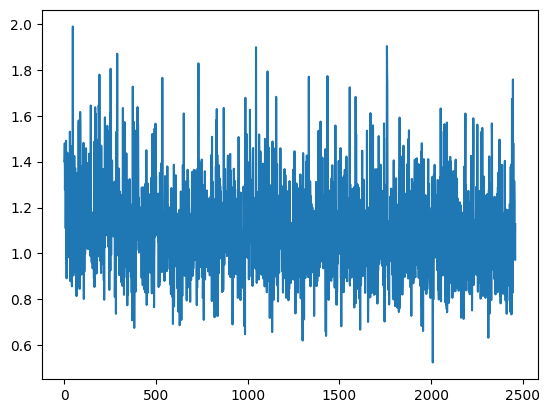

In [21]:
plt.plot(train_losses)

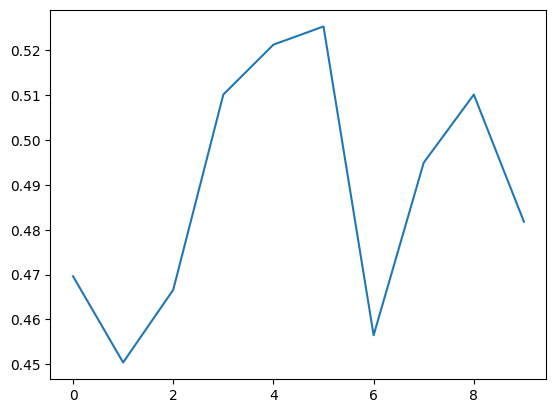

In [22]:
plt.plot(test_accuracy)

In [23]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [24]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 476/976 (0.4877)
{'acc_detail': tensor([0.0000, 0.7544, 0.5701, 0.4877], device='cuda:0'),
 'acc_unweighted': tensor(0.4531, device='cuda:0'),
 'acc_weighted': tensor(0.4877, device='cuda:0'),
 'f1s': tensor(0.4057, device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.6115, 0.6162, 0.3952], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.5141, 0.6703, 0.3322], device='cuda:0'),
 'recall_detail': tensor([0.0000, 0.7544, 0.5701, 0.4877], device='cuda:0'),
 'rocauc': tensor([0.8302, 0.7389, 0.8670, 0.7006], device='cuda:0'),
 'uar': tensor(0.4531, device='cuda:0'),
 'wap': tensor(0.3941, device='cuda:0')}


tensor([[  0,  63,   3, 155],
        [  0, 255,  49,  34],
        [  0,  82, 122,  10],
        [  0,  96,   8,  99]], device='cuda:0')

In [25]:
model_path = '../models_iemocap4/iemocap4__m18emo4_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [26]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_iemocap4/iemocap4_m18emo4_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                            | 0.003257328990228013/50 [00:00<1:33:12, 111.86s/it]

Train Epoch: 11 [0/3948 (0%)]	Loss: 1.185021
Mem before-during-after: 34492928 3535056896 42618880


  0%|                             | 0.13355048859934857/50 [00:14<1:38:58, 119.09s/it]

Train Epoch: 11 [640/3948 (16%)]	Loss: 1.039807
Mem before-during-after: 42618880 3545263104 42061824


  1%|▏                             | 0.2638436482084691/50 [00:28<1:39:44, 120.33s/it]

Train Epoch: 11 [1280/3948 (33%)]	Loss: 1.043685
Mem before-during-after: 43110400 3546089984 43110400


  1%|▏                             | 0.3941368078175897/50 [00:42<1:37:32, 117.99s/it]

Train Epoch: 11 [1920/3948 (49%)]	Loss: 1.212198
Mem before-during-after: 43110400 3546089984 43110400


  1%|▎                             | 0.5244299674267102/50 [00:56<1:37:30, 118.26s/it]

Train Epoch: 11 [2560/3948 (65%)]	Loss: 1.064993
Mem before-during-after: 43110400 3546089984 43110400


  1%|▍                             | 0.6547231270358308/50 [01:10<1:36:02, 116.78s/it]

Train Epoch: 11 [3200/3948 (81%)]	Loss: 1.038946
Mem before-during-after: 42210304 3545565696 42210304


  2%|▍                             | 0.7850162866449514/50 [01:24<1:36:39, 117.85s/it]

Train Epoch: 11 [3840/3948 (98%)]	Loss: 1.012370
Mem before-during-after: 42210304 3545565696 42210304


  2%|▋                                | 1.0000000000000002/50 [01:38<51:46, 63.40s/it]


Test Epoch: 11	Accuracy: 528/976 (53%)

saved model: ../models_iemocap4/iemocap4_m18emo4_best_11epoch.pt


  2%|▌                              | 1.0032573289902282/50 [01:38<1:02:39, 76.72s/it]

Train Epoch: 12 [0/3948 (0%)]	Loss: 1.176476
Mem before-during-after: 42206208 3544738816 43110400


  2%|▋                             | 1.1335504885993488/50 [01:52<1:33:54, 115.31s/it]

Train Epoch: 12 [640/3948 (16%)]	Loss: 0.922939
Mem before-during-after: 42061824 3546056704 42061824


  3%|▊                             | 1.2638436482084694/50 [02:06<1:33:33, 115.18s/it]

Train Epoch: 12 [1280/3948 (33%)]	Loss: 1.298588
Mem before-during-after: 42061824 3524641280 42061824


  3%|▉                               | 1.39413680781759/50 [02:19<1:34:18, 116.42s/it]

Train Epoch: 12 [1920/3948 (49%)]	Loss: 0.802531
Mem before-during-after: 42061824 3546056704 42061824


  3%|▉                             | 1.5244299674267106/50 [02:33<1:36:40, 119.65s/it]

Train Epoch: 12 [2560/3948 (65%)]	Loss: 0.969824
Mem before-during-after: 42061824 3545680896 42061824


  3%|▉                             | 1.6547231270358311/50 [02:47<1:32:51, 115.25s/it]

Train Epoch: 12 [3200/3948 (81%)]	Loss: 0.834169
Mem before-during-after: 42061824 3545778688 42061824


  4%|█                             | 1.7850162866449517/50 [03:00<1:33:54, 116.86s/it]

Train Epoch: 12 [3840/3948 (98%)]	Loss: 0.987638
Mem before-during-after: 42061824 3546056704 42061824


  4%|█▏                             | 2.0000000000000004/50 [03:15<1:00:58, 76.23s/it]


Test Epoch: 12	Accuracy: 523/976 (53%)



  4%|█▏                             | 2.0032573289902285/50 [03:15<1:08:09, 85.20s/it]

Train Epoch: 13 [0/3948 (0%)]	Loss: 1.071061
Mem before-during-after: 42057728 3545565184 42061824


  4%|█▎                             | 2.133550488599349/50 [03:29<1:33:27, 117.14s/it]

Train Epoch: 13 [640/3948 (16%)]	Loss: 0.924727
Mem before-during-after: 42061824 3546056704 42061824


  5%|█▎                            | 2.2638436482084696/50 [03:43<1:34:05, 118.26s/it]

Train Epoch: 13 [1280/3948 (33%)]	Loss: 1.595377
Mem before-during-after: 42061824 3545778688 42061824


  5%|█▌                              | 2.39413680781759/50 [03:57<1:31:46, 115.67s/it]

Train Epoch: 13 [1920/3948 (49%)]	Loss: 1.061181
Mem before-during-after: 42061824 3545778688 42061824


  5%|█▌                            | 2.5244299674267108/50 [04:10<1:32:16, 116.63s/it]

Train Epoch: 13 [2560/3948 (65%)]	Loss: 1.435755
Mem before-during-after: 42061824 3545778688 42061824


  5%|█▌                            | 2.6547231270358314/50 [04:24<1:31:36, 116.10s/it]

Train Epoch: 13 [3200/3948 (81%)]	Loss: 1.438760
Mem before-during-after: 42061824 3545958912 42061824


  6%|█▋                             | 2.785016286644952/50 [04:38<1:31:51, 116.73s/it]

Train Epoch: 13 [3840/3948 (98%)]	Loss: 1.118521
Mem before-during-after: 42061824 3546056704 42061824


  6%|██                                | 3.000000000000001/50 [04:53<51:44, 66.06s/it]


Test Epoch: 13	Accuracy: 538/976 (54%)

saved model: ../models_iemocap4/iemocap4_m18emo4_best_13epoch.pt


  6%|█▉                              | 3.003257328990229/50 [04:53<1:02:34, 79.88s/it]

Train Epoch: 14 [0/3948 (0%)]	Loss: 1.024159
Mem before-during-after: 42057728 3545565184 42061824


  6%|█▉                            | 3.1335504885993495/50 [05:07<1:29:40, 114.81s/it]

Train Epoch: 14 [640/3948 (16%)]	Loss: 0.852657
Mem before-during-after: 42061824 3545778688 42061824


  7%|██                              | 3.26384364820847/50 [05:20<1:29:35, 115.02s/it]

Train Epoch: 14 [1280/3948 (33%)]	Loss: 0.698472
Mem before-during-after: 42061824 3545778688 42061824


  7%|██                            | 3.3941368078175906/50 [05:34<1:29:23, 115.08s/it]

Train Epoch: 14 [1920/3948 (49%)]	Loss: 1.044105
Mem before-during-after: 42061824 3524641280 42061824


  7%|██▏                            | 3.524429967426711/50 [05:47<1:31:38, 118.31s/it]

Train Epoch: 14 [2560/3948 (65%)]	Loss: 1.198339
Mem before-during-after: 42061824 3546056704 42061824


  7%|██▎                            | 3.654723127035832/50 [06:01<1:30:41, 117.40s/it]

Train Epoch: 14 [3200/3948 (81%)]	Loss: 0.721847
Mem before-during-after: 42061824 3545778688 42061824


  8%|██▎                           | 3.7850162866449524/50 [06:15<1:31:11, 118.39s/it]

Train Epoch: 14 [3840/3948 (98%)]	Loss: 0.828154
Mem before-during-after: 42061824 3545778688 42061824


  8%|██▋                               | 4.000000000000001/50 [06:30<56:42, 73.97s/it]


Test Epoch: 14	Accuracy: 527/976 (53%)



  8%|██▍                            | 4.0032573289902285/50 [06:31<1:05:26, 85.36s/it]

Train Epoch: 15 [0/3948 (0%)]	Loss: 0.998375
Mem before-during-after: 42057728 3545565184 42061824


  8%|██▌                            | 4.133550488599331/50 [06:45<1:32:28, 120.97s/it]

Train Epoch: 15 [640/3948 (16%)]	Loss: 0.953878
Mem before-during-after: 42061824 3546056704 42061824


  9%|██▋                            | 4.263843648208434/50 [06:59<1:31:51, 120.51s/it]

Train Epoch: 15 [1280/3948 (33%)]	Loss: 1.112130
Mem before-during-after: 42061824 3546056704 42061824


  9%|██▋                            | 4.394136807817537/50 [07:13<1:28:52, 116.91s/it]

Train Epoch: 15 [1920/3948 (49%)]	Loss: 1.072643
Mem before-during-after: 42061824 3546056704 42061824


  9%|██▉                             | 4.52442996742664/50 [07:26<1:28:59, 117.41s/it]

Train Epoch: 15 [2560/3948 (65%)]	Loss: 0.941918
Mem before-during-after: 42061824 3546056704 42061824


  9%|██▊                           | 4.6547231270357425/50 [07:40<1:30:26, 119.67s/it]

Train Epoch: 15 [3200/3948 (81%)]	Loss: 1.235176
Mem before-during-after: 42061824 3545680896 42061824


 10%|██▉                            | 4.785016286644845/50 [07:54<1:28:40, 117.68s/it]

Train Epoch: 15 [3840/3948 (98%)]	Loss: 0.998248
Mem before-during-after: 42061824 3546056704 42061824


 10%|███▍                              | 4.999999999999865/50 [08:09<48:39, 64.88s/it]


Test Epoch: 15	Accuracy: 532/976 (54%)



 10%|███▍                              | 5.003257328990093/50 [08:09<57:56, 77.27s/it]

Train Epoch: 16 [0/3948 (0%)]	Loss: 1.059251
Mem before-during-after: 42057728 3545565184 42061824


 10%|███▏                           | 5.133550488599195/50 [08:23<1:27:26, 116.95s/it]

Train Epoch: 16 [640/3948 (16%)]	Loss: 0.870267
Mem before-during-after: 42061824 3546056704 42061824


 11%|███▎                           | 5.263843648208298/50 [08:37<1:26:45, 116.36s/it]

Train Epoch: 16 [1280/3948 (33%)]	Loss: 1.002820
Mem before-during-after: 42061824 3546056704 42061824


 11%|███▎                           | 5.394136807817401/50 [08:50<1:26:09, 115.88s/it]

Train Epoch: 16 [1920/3948 (49%)]	Loss: 1.268886
Mem before-during-after: 42061824 3545778688 42061824


 11%|███▍                           | 5.524429967426504/50 [09:04<1:26:55, 117.27s/it]

Train Epoch: 16 [2560/3948 (65%)]	Loss: 0.845028
Mem before-during-after: 42061824 3546056704 42061824


 11%|███▌                           | 5.654723127035607/50 [09:18<1:29:30, 121.10s/it]

Train Epoch: 16 [3200/3948 (81%)]	Loss: 0.764930
Mem before-during-after: 42061824 3546056704 42061824


 12%|███▍                          | 5.7850162866447095/50 [09:32<1:27:10, 118.29s/it]

Train Epoch: 16 [3840/3948 (98%)]	Loss: 0.759882
Mem before-during-after: 42061824 3546056704 42061824


 12%|████                              | 5.999999999999729/50 [09:47<47:46, 65.15s/it]


Test Epoch: 16	Accuracy: 529/976 (54%)



 12%|████                              | 6.003257328989957/50 [09:47<57:06, 77.89s/it]

Train Epoch: 17 [0/3948 (0%)]	Loss: 1.126898
Mem before-during-after: 42057728 3545565184 42061824


 12%|███▋                          | 6.1335504885990595/50 [10:01<1:27:01, 119.04s/it]

Train Epoch: 17 [640/3948 (16%)]	Loss: 1.193322
Mem before-during-after: 42061824 3546056704 42061824


 13%|███▉                           | 6.263843648208162/50 [10:15<1:30:37, 124.33s/it]

Train Epoch: 17 [1280/3948 (33%)]	Loss: 1.140298
Mem before-during-after: 42061824 3545778688 42061824


 13%|███▉                           | 6.394136807817265/50 [10:28<1:24:52, 116.79s/it]

Train Epoch: 17 [1920/3948 (49%)]	Loss: 0.936261
Mem before-during-after: 42061824 3546056704 42061824


 13%|████                           | 6.524429967426368/50 [10:42<1:24:00, 115.95s/it]

Train Epoch: 17 [2560/3948 (65%)]	Loss: 0.847150
Mem before-during-after: 42061824 3545778688 42061824


 13%|████▏                          | 6.654723127035471/50 [10:56<1:27:33, 121.20s/it]

Train Epoch: 17 [3200/3948 (81%)]	Loss: 0.834149
Mem before-during-after: 42061824 3546056704 42061824


 14%|████▏                          | 6.785016286644574/50 [11:10<1:24:39, 117.54s/it]

Train Epoch: 17 [3840/3948 (98%)]	Loss: 0.941893
Mem before-during-after: 42061824 3546044416 42061824


 14%|████▊                             | 6.999999999999593/50 [11:24<45:28, 63.46s/it]


Test Epoch: 17	Accuracy: 529/976 (54%)



 14%|████▊                             | 7.003257328989821/50 [11:25<55:15, 77.10s/it]

Train Epoch: 18 [0/3948 (0%)]	Loss: 1.025228
Mem before-during-after: 42057728 3545565184 42061824


 14%|████▍                          | 7.133550488598924/50 [11:39<1:23:18, 116.60s/it]

Train Epoch: 18 [640/3948 (16%)]	Loss: 0.879057
Mem before-during-after: 42061824 3545778688 42061824


 15%|████▌                          | 7.263843648208026/50 [11:52<1:25:31, 120.08s/it]

Train Epoch: 18 [1280/3948 (33%)]	Loss: 1.022158
Mem before-during-after: 42061824 3545680896 42061824


 15%|████▌                          | 7.394136807817129/50 [12:06<1:22:54, 116.76s/it]

Train Epoch: 18 [1920/3948 (49%)]	Loss: 1.025672
Mem before-during-after: 42061824 3546056704 42061824


 15%|████▋                          | 7.524429967426232/50 [12:20<1:22:54, 117.11s/it]

Train Epoch: 18 [2560/3948 (65%)]	Loss: 1.025413
Mem before-during-after: 42061824 3545778688 42061824


 15%|████▋                          | 7.654723127035335/50 [12:34<1:22:33, 116.98s/it]

Train Epoch: 18 [3200/3948 (81%)]	Loss: 0.959998
Mem before-during-after: 42061824 3546056704 42061824


 16%|████▊                          | 7.785016286644438/50 [12:48<1:22:23, 117.10s/it]

Train Epoch: 18 [3840/3948 (98%)]	Loss: 1.065931
Mem before-during-after: 42061824 3546056704 42061824


 16%|█████▍                            | 7.999999999999457/50 [13:02<46:51, 66.94s/it]


Test Epoch: 18	Accuracy: 529/976 (54%)



 16%|█████▍                            | 8.003257328989685/50 [13:03<54:22, 77.68s/it]

Train Epoch: 19 [0/3948 (0%)]	Loss: 0.946735
Mem before-during-after: 42057728 3545565184 42061824


 16%|█████                          | 8.133550488598823/50 [13:16<1:21:33, 116.88s/it]

Train Epoch: 19 [640/3948 (16%)]	Loss: 0.994737
Mem before-during-after: 42061824 3546056704 42061824


 17%|█████                          | 8.263843648207962/50 [13:30<1:21:06, 116.61s/it]

Train Epoch: 19 [1280/3948 (33%)]	Loss: 1.098786
Mem before-during-after: 42061824 3545778688 42061824


 17%|█████▌                           | 8.3941368078171/50 [13:44<1:21:34, 117.64s/it]

Train Epoch: 19 [1920/3948 (49%)]	Loss: 1.131625
Mem before-during-after: 42061824 3545778688 42061824


 17%|█████▎                         | 8.524429967426238/50 [13:58<1:20:48, 116.89s/it]

Train Epoch: 19 [2560/3948 (65%)]	Loss: 0.949316
Mem before-during-after: 42061824 3545778688 42061824


 17%|█████▎                         | 8.654723127035377/50 [14:11<1:20:37, 117.00s/it]

Train Epoch: 19 [3200/3948 (81%)]	Loss: 0.799144
Mem before-during-after: 42061824 3546056704 42061824


 18%|█████▍                         | 8.785016286644515/50 [14:25<1:21:37, 118.83s/it]

Train Epoch: 19 [3840/3948 (98%)]	Loss: 0.620280
Mem before-during-after: 42061824 3545572864 42061824


 18%|██████                            | 8.999999999999593/50 [14:40<43:54, 64.26s/it]


Test Epoch: 19	Accuracy: 533/976 (54%)



 18%|██████                            | 9.003257328989822/50 [14:40<52:21, 76.62s/it]

Train Epoch: 20 [0/3948 (0%)]	Loss: 0.981330
Mem before-during-after: 42057728 3545565184 42061824


 18%|█████▊                          | 9.13355048859896/50 [14:54<1:20:24, 118.06s/it]

Train Epoch: 20 [640/3948 (16%)]	Loss: 1.127870
Mem before-during-after: 42061824 3546056704 42061824


 19%|█████▋                         | 9.263843648208098/50 [15:08<1:20:07, 118.01s/it]

Train Epoch: 20 [1280/3948 (33%)]	Loss: 1.059047
Mem before-during-after: 42061824 3545680896 42061824


 19%|█████▊                         | 9.394136807817237/50 [15:22<1:18:44, 116.36s/it]

Train Epoch: 20 [1920/3948 (49%)]	Loss: 1.381262
Mem before-during-after: 42061824 3546056704 42061824


 19%|█████▉                         | 9.524429967426375/50 [15:36<1:20:37, 119.52s/it]

Train Epoch: 20 [2560/3948 (65%)]	Loss: 0.626171
Mem before-during-after: 42061824 3545778688 42061824


 19%|█████▉                         | 9.654723127035513/50 [15:49<1:17:55, 115.89s/it]

Train Epoch: 20 [3200/3948 (81%)]	Loss: 0.788759
Mem before-during-after: 42061824 3545778688 42061824


 20%|██████                         | 9.785016286644652/50 [16:03<1:19:50, 119.12s/it]

Train Epoch: 20 [3840/3948 (98%)]	Loss: 0.907293
Mem before-during-after: 42061824 3546056704 42061824


 20%|██████▉                            | 9.99999999999973/50 [16:18<42:41, 64.04s/it]


Test Epoch: 20	Accuracy: 529/976 (54%)



 20%|██████▌                          | 10.003257328989958/50 [16:18<51:14, 76.86s/it]

Train Epoch: 21 [0/3948 (0%)]	Loss: 1.177875
Mem before-during-after: 42057728 3545565184 42061824


 20%|██████                        | 10.133550488599097/50 [16:32<1:17:06, 116.06s/it]

Train Epoch: 21 [640/3948 (16%)]	Loss: 1.145251
Mem before-during-after: 42061824 3545778688 42061824


 21%|██████▏                       | 10.263843648208235/50 [16:46<1:17:24, 116.88s/it]

Train Epoch: 21 [1280/3948 (33%)]	Loss: 0.919794
Mem before-during-after: 42061824 3546056704 42061824


 21%|██████▏                       | 10.394136807817373/50 [17:00<1:17:47, 117.84s/it]

Train Epoch: 21 [1920/3948 (49%)]	Loss: 1.067388
Mem before-during-after: 42061824 3546056704 42061824


 21%|██████▎                       | 10.524429967426512/50 [17:14<1:17:53, 118.39s/it]

Train Epoch: 21 [2560/3948 (65%)]	Loss: 1.119535
Mem before-during-after: 42061824 3546056704 42061824


 21%|██████▌                        | 10.65472312703565/50 [17:27<1:17:52, 118.75s/it]

Train Epoch: 21 [3200/3948 (81%)]	Loss: 1.500580
Mem before-during-after: 42061824 3546056704 42061824


 22%|██████▍                       | 10.785016286644789/50 [17:42<1:17:09, 118.04s/it]

Train Epoch: 21 [3840/3948 (98%)]	Loss: 1.063445
Mem before-during-after: 42061824 3546056704 42061824


 22%|███████▎                         | 10.999999999999867/50 [17:56<42:12, 64.95s/it]


Test Epoch: 21	Accuracy: 528/976 (53%)



 22%|███████▎                         | 11.003257328990095/50 [17:57<50:26, 77.60s/it]

Train Epoch: 22 [0/3948 (0%)]	Loss: 0.952349
Mem before-during-after: 42057728 3545565184 42061824


 22%|██████▋                       | 11.133550488599234/50 [18:10<1:16:17, 117.78s/it]

Train Epoch: 22 [640/3948 (16%)]	Loss: 0.688021
Mem before-during-after: 42061824 3546056704 42061824


 23%|██████▊                       | 11.263843648208372/50 [18:24<1:15:03, 116.27s/it]

Train Epoch: 22 [1280/3948 (33%)]	Loss: 0.990770
Mem before-during-after: 42061824 3545778688 42061824


 23%|███████                        | 11.39413680781751/50 [18:38<1:15:07, 116.77s/it]

Train Epoch: 22 [1920/3948 (49%)]	Loss: 1.208227
Mem before-during-after: 42061824 3546056704 42061824


 23%|██████▉                       | 11.524429967426649/50 [18:51<1:14:15, 115.80s/it]

Train Epoch: 22 [2560/3948 (65%)]	Loss: 0.996224
Mem before-during-after: 42061824 3545778688 42061824


 23%|██████▉                       | 11.654723127035787/50 [19:05<1:16:25, 119.58s/it]

Train Epoch: 22 [3200/3948 (81%)]	Loss: 0.779759
Mem before-during-after: 42061824 3545999360 42061824


 24%|███████                       | 11.785016286644925/50 [19:19<1:13:59, 116.18s/it]

Train Epoch: 22 [3840/3948 (98%)]	Loss: 0.713201
Mem before-during-after: 42061824 3545778688 42061824


 24%|███████▉                         | 12.000000000000004/50 [19:34<39:48, 62.86s/it]


Test Epoch: 22	Accuracy: 532/976 (54%)



 24%|███████▉                         | 12.003257328990232/50 [19:34<48:25, 76.48s/it]

Train Epoch: 23 [0/3948 (0%)]	Loss: 1.019401
Mem before-during-after: 42057728 3545565184 42061824


 24%|███████▌                       | 12.13355048859937/50 [19:48<1:16:14, 120.81s/it]

Train Epoch: 23 [640/3948 (16%)]	Loss: 1.031739
Mem before-during-after: 42061824 3546056704 42061824


 25%|███████▎                      | 12.263843648208509/50 [20:01<1:13:42, 117.19s/it]

Train Epoch: 23 [1280/3948 (33%)]	Loss: 0.861176
Mem before-during-after: 42061824 3546056704 42061824


 25%|███████▍                      | 12.394136807817647/50 [20:15<1:13:29, 117.26s/it]

Train Epoch: 23 [1920/3948 (49%)]	Loss: 0.955727
Mem before-during-after: 42061824 3546056704 42061824


 25%|███████▌                      | 12.524429967426785/50 [20:29<1:12:33, 116.18s/it]

Train Epoch: 23 [2560/3948 (65%)]	Loss: 1.007554
Mem before-during-after: 42061824 3545778688 42061824


 25%|███████▌                      | 12.654723127035924/50 [20:43<1:14:44, 120.08s/it]

Train Epoch: 23 [3200/3948 (81%)]	Loss: 1.313532
Mem before-during-after: 42061824 3545680896 42061824


 26%|███████▋                      | 12.785016286645062/50 [20:57<1:12:35, 117.04s/it]

Train Epoch: 23 [3840/3948 (98%)]	Loss: 1.009798
Mem before-during-after: 42061824 3546056704 42061824


 26%|████████▊                         | 13.00000000000014/50 [21:11<41:19, 67.02s/it]


Test Epoch: 23	Accuracy: 527/976 (53%)



 26%|████████▌                        | 13.003257328990369/50 [21:12<48:50, 79.20s/it]

Train Epoch: 24 [0/3948 (0%)]	Loss: 0.692266
Mem before-during-after: 42057728 3545565184 42061824


 26%|███████▉                      | 13.133550488599507/50 [21:25<1:12:39, 118.26s/it]

Train Epoch: 24 [640/3948 (16%)]	Loss: 1.011519
Mem before-during-after: 42061824 3546056704 42061824


 27%|███████▉                      | 13.263843648208645/50 [21:39<1:14:15, 121.29s/it]

Train Epoch: 24 [1280/3948 (33%)]	Loss: 0.906546
Mem before-during-after: 42061824 3546056704 42061824


 27%|████████                      | 13.394136807817784/50 [21:53<1:11:40, 117.49s/it]

Train Epoch: 24 [1920/3948 (49%)]	Loss: 1.202159
Mem before-during-after: 42061824 3546056704 42061824


 27%|████████                      | 13.524429967426922/50 [22:07<1:10:30, 115.97s/it]

Train Epoch: 24 [2560/3948 (65%)]	Loss: 0.824393
Mem before-during-after: 42061824 3545778688 42061824


 27%|████████▍                      | 13.65472312703606/50 [22:21<1:10:42, 116.73s/it]

Train Epoch: 24 [3200/3948 (81%)]	Loss: 1.140065
Mem before-during-after: 42061824 3545778688 42061824


 28%|████████▎                     | 13.785016286645199/50 [22:34<1:11:06, 117.81s/it]

Train Epoch: 24 [3840/3948 (98%)]	Loss: 0.607153
Mem before-during-after: 42061824 3545680896 42061824


 28%|█████████▏                       | 14.000000000000277/50 [22:49<37:43, 62.88s/it]


Test Epoch: 24	Accuracy: 533/976 (54%)



 28%|█████████▏                       | 14.003257328990506/50 [22:49<46:24, 77.37s/it]

Train Epoch: 25 [0/3948 (0%)]	Loss: 0.840104
Mem before-during-after: 42057728 3545565184 42061824


 28%|████████▍                     | 14.133550488599644/50 [23:03<1:10:23, 117.76s/it]

Train Epoch: 25 [640/3948 (16%)]	Loss: 0.763173
Mem before-during-after: 42061824 3545778688 42061824


 29%|████████▌                     | 14.263843648208782/50 [23:17<1:10:34, 118.50s/it]

Train Epoch: 25 [1280/3948 (33%)]	Loss: 1.380672
Mem before-during-after: 42061824 3546056704 42061824


 29%|████████▉                      | 14.39413680781792/50 [23:31<1:09:50, 117.69s/it]

Train Epoch: 25 [1920/3948 (49%)]	Loss: 1.385982
Mem before-during-after: 42061824 3546056704 42061824


 29%|████████▋                     | 14.524429967427059/50 [23:45<1:10:08, 118.62s/it]

Train Epoch: 25 [2560/3948 (65%)]	Loss: 1.025476
Mem before-during-after: 42061824 3545778688 42061824


 29%|████████▊                     | 14.654723127036197/50 [23:59<1:09:18, 117.66s/it]

Train Epoch: 25 [3200/3948 (81%)]	Loss: 0.917212
Mem before-during-after: 42061824 3546056704 42061824


 30%|████████▊                     | 14.785016286645336/50 [24:13<1:08:38, 116.95s/it]

Train Epoch: 25 [3840/3948 (98%)]	Loss: 1.057315
Mem before-during-after: 42061824 3545778688 42061824


 30%|█████████▉                       | 15.000000000000414/50 [24:27<37:06, 63.61s/it]


Test Epoch: 25	Accuracy: 520/976 (53%)



 30%|█████████▉                       | 15.003257328990642/50 [24:28<44:47, 76.79s/it]

Train Epoch: 26 [0/3948 (0%)]	Loss: 0.910237
Mem before-during-after: 42057728 3525507584 42061824


 30%|█████████▍                     | 15.13355048859978/50 [24:42<1:07:51, 116.76s/it]

Train Epoch: 26 [640/3948 (16%)]	Loss: 0.857430
Mem before-during-after: 42061824 3545778688 42061824


 31%|█████████▏                    | 15.263843648208919/50 [24:56<1:08:07, 117.67s/it]

Train Epoch: 26 [1280/3948 (33%)]	Loss: 1.239048
Mem before-during-after: 42061824 3545778688 42061824


 31%|█████████▏                    | 15.394136807818057/50 [25:09<1:07:08, 116.42s/it]

Train Epoch: 26 [1920/3948 (49%)]	Loss: 1.023749
Mem before-during-after: 42061824 3545778688 42061824


 31%|█████████▎                    | 15.524429967427196/50 [25:23<1:07:14, 117.02s/it]

Train Epoch: 26 [2560/3948 (65%)]	Loss: 1.007292
Mem before-during-after: 42061824 3545778688 42061824


 31%|█████████▍                    | 15.654723127036334/50 [25:37<1:06:09, 115.59s/it]

Train Epoch: 26 [3200/3948 (81%)]	Loss: 0.905842
Mem before-during-after: 42061824 3545778688 42061824


 32%|█████████▍                    | 15.785016286645472/50 [25:50<1:06:24, 116.45s/it]

Train Epoch: 26 [3840/3948 (98%)]	Loss: 0.996081
Mem before-during-after: 42061824 3545778688 42061824


 32%|██████████▉                       | 16.00000000000055/50 [26:05<36:03, 63.64s/it]


Test Epoch: 26	Accuracy: 524/976 (53%)



 32%|██████████▌                      | 16.003257328990777/50 [26:05<43:28, 76.74s/it]

Train Epoch: 27 [0/3948 (0%)]	Loss: 0.705814
Mem before-during-after: 42057728 3545565184 42061824


 32%|█████████▋                    | 16.133550488599845/50 [26:19<1:05:59, 116.90s/it]

Train Epoch: 27 [640/3948 (16%)]	Loss: 0.928100
Mem before-during-after: 42061824 3546056704 42061824


 33%|█████████▊                    | 16.263843648208912/50 [26:33<1:05:42, 116.85s/it]

Train Epoch: 27 [1280/3948 (33%)]	Loss: 1.208791
Mem before-during-after: 42061824 3545778688 42061824


 33%|██████████▏                    | 16.39413680781798/50 [26:46<1:04:59, 116.04s/it]

Train Epoch: 27 [1920/3948 (49%)]	Loss: 1.206687
Mem before-during-after: 42061824 3545778688 42061824


 33%|█████████▉                    | 16.524429967427047/50 [27:00<1:05:20, 117.11s/it]

Train Epoch: 27 [2560/3948 (65%)]	Loss: 0.877638
Mem before-during-after: 42061824 3525474816 42061824


 33%|█████████▉                    | 16.654723127036114/50 [27:14<1:04:37, 116.27s/it]

Train Epoch: 27 [3200/3948 (81%)]	Loss: 0.900326
Mem before-during-after: 42061824 3545778688 42061824


 34%|██████████▍                    | 16.78501628664518/50 [27:28<1:04:37, 116.74s/it]

Train Epoch: 27 [3840/3948 (98%)]	Loss: 1.374914
Mem before-during-after: 42061824 3546056704 42061824


 34%|███████████▏                     | 17.000000000000142/50 [27:42<36:04, 65.58s/it]


Test Epoch: 27	Accuracy: 519/976 (53%)



 34%|███████████▌                      | 17.00325732899037/50 [27:43<43:16, 78.69s/it]

Train Epoch: 28 [0/3948 (0%)]	Loss: 0.797714
Mem before-during-after: 42057728 3525507584 42061824


 34%|██████████▎                   | 17.133550488599436/50 [27:57<1:03:48, 116.48s/it]

Train Epoch: 28 [640/3948 (16%)]	Loss: 0.860661
Mem before-during-after: 42061824 3546056704 42061824


 35%|██████████▎                   | 17.263843648208503/50 [28:10<1:03:14, 115.90s/it]

Train Epoch: 28 [1280/3948 (33%)]	Loss: 1.031083
Mem before-during-after: 42061824 3545778688 42061824


 35%|██████████▊                    | 17.39413680781757/50 [28:24<1:03:50, 117.49s/it]

Train Epoch: 28 [1920/3948 (49%)]	Loss: 0.597649
Mem before-during-after: 42061824 3545778688 42061824


 35%|██████████▌                   | 17.524429967426638/50 [28:38<1:04:18, 118.81s/it]

Train Epoch: 28 [2560/3948 (65%)]	Loss: 0.974437
Mem before-during-after: 42061824 3545778688 42061824


 35%|██████████▌                   | 17.654723127035705/50 [28:52<1:02:58, 116.82s/it]

Train Epoch: 28 [3200/3948 (81%)]	Loss: 1.250553
Mem before-during-after: 42061824 3546056704 42061824


 36%|██████████▋                   | 17.785016286644773/50 [29:05<1:03:02, 117.43s/it]

Train Epoch: 28 [3840/3948 (98%)]	Loss: 0.897447
Mem before-during-after: 42061824 3545778688 42061824


 36%|███████████▉                     | 17.999999999999734/50 [29:20<33:42, 63.22s/it]


Test Epoch: 28	Accuracy: 521/976 (53%)



 36%|████████████▏                     | 18.00325732898996/50 [29:20<40:48, 76.53s/it]

Train Epoch: 29 [0/3948 (0%)]	Loss: 0.747507
Mem before-during-after: 42057728 3545565184 42061824


 36%|██████████▉                   | 18.133550488599028/50 [29:34<1:02:27, 117.59s/it]

Train Epoch: 29 [640/3948 (16%)]	Loss: 1.091693
Mem before-during-after: 42061824 3546056704 42061824


 37%|██████████▉                   | 18.263843648208095/50 [29:48<1:01:54, 117.05s/it]

Train Epoch: 29 [1280/3948 (33%)]	Loss: 1.048381
Mem before-during-after: 42061824 3546056704 42061824


 37%|███████████                   | 18.394136807817162/50 [30:01<1:01:57, 117.62s/it]

Train Epoch: 29 [1920/3948 (49%)]	Loss: 1.125126
Mem before-during-after: 42061824 3546056704 42061824


 37%|███████████▍                   | 18.52442996742623/50 [30:15<1:00:45, 115.83s/it]

Train Epoch: 29 [2560/3948 (65%)]	Loss: 1.008378
Mem before-during-after: 42061824 3545778688 42061824


 37%|███████████▏                  | 18.654723127035297/50 [30:29<1:03:45, 122.05s/it]

Train Epoch: 29 [3200/3948 (81%)]	Loss: 0.928921
Mem before-during-after: 42061824 3545680896 42061824


 38%|███████████▎                  | 18.785016286644364/50 [30:43<1:01:18, 117.84s/it]

Train Epoch: 29 [3840/3948 (98%)]	Loss: 0.932821
Mem before-during-after: 42061824 3545999360 42061824


 38%|████████████▌                    | 18.999999999999325/50 [30:57<33:40, 65.18s/it]


Test Epoch: 29	Accuracy: 520/976 (53%)



 38%|████████████▉                     | 19.00325732898955/50 [30:58<40:12, 77.84s/it]

Train Epoch: 30 [0/3948 (0%)]	Loss: 1.068761
Mem before-during-after: 42057728 3545565184 42061824


 38%|███████████▊                   | 19.13355048859862/50 [31:11<1:00:31, 117.65s/it]

Train Epoch: 30 [640/3948 (16%)]	Loss: 0.851741
Mem before-during-after: 42061824 3546056704 42061824


 39%|███████████▌                  | 19.263843648207686/50 [31:25<1:00:40, 118.44s/it]

Train Epoch: 30 [1280/3948 (33%)]	Loss: 0.846297
Mem before-during-after: 42061824 3546056704 42061824


 39%|████████████▍                   | 19.394136807816754/50 [31:39<59:25, 116.49s/it]

Train Epoch: 30 [1920/3948 (49%)]	Loss: 0.924919
Mem before-during-after: 42061824 3546056704 42061824


 39%|████████████▉                    | 19.52442996742582/50 [31:53<59:22, 116.89s/it]

Train Epoch: 30 [2560/3948 (65%)]	Loss: 0.967922
Mem before-during-after: 42061824 3546056704 42061824


 39%|████████████▌                   | 19.654723127034888/50 [32:07<58:42, 116.08s/it]

Train Epoch: 30 [3200/3948 (81%)]	Loss: 0.705826
Mem before-during-after: 42061824 3524592128 42061824


 40%|████████████▋                   | 19.785016286643955/50 [32:21<59:13, 117.59s/it]

Train Epoch: 30 [3840/3948 (98%)]	Loss: 0.904374
Mem before-during-after: 42061824 3545572864 42061824


 40%|█████████████▏                   | 19.999999999998916/50 [32:35<32:09, 64.31s/it]


Test Epoch: 30	Accuracy: 538/976 (54%)



 40%|█████████████▏                   | 20.003257328989143/50 [32:36<38:43, 77.44s/it]

Train Epoch: 31 [0/3948 (0%)]	Loss: 0.982590
Mem before-during-after: 42057728 3545565184 42061824


 40%|█████████████▎                   | 20.13355048859821/50 [32:50<59:38, 119.83s/it]

Train Epoch: 31 [640/3948 (16%)]	Loss: 1.124557
Mem before-during-after: 42061824 3546056704 42061824


 41%|████████████▉                   | 20.263843648207278/50 [33:03<58:32, 118.13s/it]

Train Epoch: 31 [1280/3948 (33%)]	Loss: 0.720972
Mem before-during-after: 42061824 3546056704 42061824


 41%|█████████████                   | 20.394136807816345/50 [33:17<58:14, 118.05s/it]

Train Epoch: 31 [1920/3948 (49%)]	Loss: 0.595978
Mem before-during-after: 42061824 3545778688 42061824


 41%|█████████████▏                  | 20.524429967425412/50 [33:31<57:52, 117.80s/it]

Train Epoch: 31 [2560/3948 (65%)]	Loss: 1.120048
Mem before-during-after: 42061824 3545786368 42061824


 41%|█████████████▋                   | 20.65472312703448/50 [33:45<57:49, 118.22s/it]

Train Epoch: 31 [3200/3948 (81%)]	Loss: 0.812973
Mem before-during-after: 42061824 3546056704 42061824


 42%|█████████████▎                  | 20.785016286643547/50 [33:59<57:39, 118.41s/it]

Train Epoch: 31 [3840/3948 (98%)]	Loss: 0.552884
Mem before-during-after: 42061824 3545958912 42061824


 42%|█████████████▊                   | 20.999999999998508/50 [34:14<31:10, 64.52s/it]


Test Epoch: 31	Accuracy: 523/976 (53%)



 42%|█████████████▊                   | 21.003257328988735/50 [34:14<37:39, 77.93s/it]

Train Epoch: 32 [0/3948 (0%)]	Loss: 1.085804
Mem before-during-after: 42057728 3545565184 42061824


 42%|█████████████▌                  | 21.133550488597802/50 [34:28<56:35, 117.61s/it]

Train Epoch: 32 [640/3948 (16%)]	Loss: 0.731023
Mem before-during-after: 42061824 3546056704 42061824


 43%|██████████████                   | 21.26384364820687/50 [34:42<56:06, 117.15s/it]

Train Epoch: 32 [1280/3948 (33%)]	Loss: 0.965710
Mem before-during-after: 42061824 3546056704 42061824


 43%|█████████████▋                  | 21.394136807815936/50 [34:55<55:30, 116.42s/it]

Train Epoch: 32 [1920/3948 (49%)]	Loss: 0.923619
Mem before-during-after: 42061824 3546056704 42061824


 43%|█████████████▊                  | 21.524429967425004/50 [35:09<55:32, 117.03s/it]

Train Epoch: 32 [2560/3948 (65%)]	Loss: 0.872832
Mem before-during-after: 42061824 3546056704 42061824


 43%|██████████████▎                  | 21.65472312703407/50 [35:23<55:28, 117.42s/it]

Train Epoch: 32 [3200/3948 (81%)]	Loss: 1.083932
Mem before-during-after: 42061824 3546056704 42061824


 44%|██████████████▍                  | 21.78501628664314/50 [35:37<55:18, 117.63s/it]

Train Epoch: 32 [3840/3948 (98%)]	Loss: 0.771025
Mem before-during-after: 42061824 3545778688 42061824


 44%|███████████████▍                   | 21.9999999999981/50 [35:51<30:14, 64.79s/it]


Test Epoch: 32	Accuracy: 520/976 (53%)



 44%|██████████████▌                  | 22.003257328988326/50 [35:52<36:13, 77.62s/it]

Train Epoch: 33 [0/3948 (0%)]	Loss: 0.662362
Mem before-during-after: 42057728 3545565184 42061824


 44%|██████████████▏                 | 22.133550488597393/50 [36:05<54:06, 116.49s/it]

Train Epoch: 33 [640/3948 (16%)]	Loss: 0.703002
Mem before-during-after: 42061824 3546056704 42061824


 45%|██████████████▋                  | 22.26384364820646/50 [36:19<54:54, 118.79s/it]

Train Epoch: 33 [1280/3948 (33%)]	Loss: 0.856890
Mem before-during-after: 42061824 3546056704 42061824


 45%|██████████████▎                 | 22.394136807815528/50 [36:33<53:40, 116.66s/it]

Train Epoch: 33 [1920/3948 (49%)]	Loss: 0.895312
Mem before-during-after: 42061824 3546056704 42061824


 45%|██████████████▍                 | 22.524429967424595/50 [36:47<53:00, 115.74s/it]

Train Epoch: 33 [2560/3948 (65%)]	Loss: 0.825780
Mem before-during-after: 42061824 3545778688 42061824


 45%|██████████████▍                 | 22.654723127033662/50 [37:01<53:56, 118.35s/it]

Train Epoch: 33 [3200/3948 (81%)]	Loss: 1.278315
Mem before-during-after: 42061824 3546056704 42061824


 46%|███████████████                  | 22.78501628664273/50 [37:15<53:15, 117.43s/it]

Train Epoch: 33 [3840/3948 (98%)]	Loss: 1.019029
Mem before-during-after: 42061824 3546056704 42061824


 46%|███████████████▋                  | 22.99999999999769/50 [37:30<29:22, 65.27s/it]


Test Epoch: 33	Accuracy: 526/976 (53%)



 46%|███████████████▏                 | 23.003257328987917/50 [37:30<34:56, 77.67s/it]

Train Epoch: 34 [0/3948 (0%)]	Loss: 0.809642
Mem before-during-after: 42057728 3545565184 42061824


 46%|██████████████▊                 | 23.133550488596985/50 [37:44<52:49, 117.96s/it]

Train Epoch: 34 [640/3948 (16%)]	Loss: 1.073960
Mem before-during-after: 42061824 3545958912 42061824


 47%|██████████████▉                 | 23.263843648206052/50 [37:58<53:05, 119.16s/it]

Train Epoch: 34 [1280/3948 (33%)]	Loss: 0.961093
Mem before-during-after: 42061824 3545572864 42061824


 47%|███████████████▍                 | 23.39413680781512/50 [38:11<53:23, 120.40s/it]

Train Epoch: 34 [1920/3948 (49%)]	Loss: 0.722337
Mem before-during-after: 42061824 3545778688 42061824


 47%|███████████████                 | 23.524429967424187/50 [38:25<51:16, 116.22s/it]

Train Epoch: 34 [2560/3948 (65%)]	Loss: 0.888734
Mem before-during-after: 42061824 3545778688 42061824


 47%|███████████████▏                | 23.654723127033254/50 [38:39<51:41, 117.74s/it]

Train Epoch: 34 [3200/3948 (81%)]	Loss: 0.908664
Mem before-during-after: 42061824 3546056704 42061824


 48%|███████████████▋                 | 23.78501628664232/50 [38:53<50:32, 115.66s/it]

Train Epoch: 34 [3840/3948 (98%)]	Loss: 1.092901
Mem before-during-after: 42061824 3545778688 42061824


 48%|███████████████▊                 | 23.999999999997282/50 [39:07<28:01, 64.69s/it]


Test Epoch: 34	Accuracy: 515/976 (52%)



 48%|████████████████▎                 | 24.00325732898751/50 [39:08<33:22, 77.03s/it]

Train Epoch: 35 [0/3948 (0%)]	Loss: 0.807498
Mem before-during-after: 42057728 3545565184 42061824


 48%|███████████████▍                | 24.133550488596576/50 [39:21<50:00, 115.99s/it]

Train Epoch: 35 [640/3948 (16%)]	Loss: 1.082723
Mem before-during-after: 42061824 3545778688 42061824


 49%|███████████████▌                | 24.263843648205643/50 [39:35<50:30, 117.73s/it]

Train Epoch: 35 [1280/3948 (33%)]	Loss: 0.920982
Mem before-during-after: 42061824 3545999360 42061824


 49%|████████████████                 | 24.39413680781471/50 [39:49<50:04, 117.32s/it]

Train Epoch: 35 [1920/3948 (49%)]	Loss: 0.698508
Mem before-during-after: 42061824 3546056704 42061824


 49%|███████████████▋                | 24.524429967423778/50 [40:03<49:08, 115.75s/it]

Train Epoch: 35 [2560/3948 (65%)]	Loss: 0.715978
Mem before-during-after: 42061824 3545778688 42061824


 49%|███████████████▊                | 24.654723127032845/50 [40:16<49:25, 116.99s/it]

Train Epoch: 35 [3200/3948 (81%)]	Loss: 0.930853
Mem before-during-after: 42061824 3546056704 42061824


 50%|███████████████▊                | 24.785016286641913/50 [40:31<51:14, 121.93s/it]

Train Epoch: 35 [3840/3948 (98%)]	Loss: 0.758758
Mem before-during-after: 42061824 3545999360 42061824


 50%|████████████████▍                | 24.999999999996874/50 [40:46<27:10, 65.21s/it]


Test Epoch: 35	Accuracy: 517/976 (52%)



 50%|█████████████████▌                 | 25.0032573289871/50 [40:46<32:32, 78.11s/it]

Train Epoch: 36 [0/3948 (0%)]	Loss: 0.859225
Mem before-during-after: 42057728 3545565184 42061824


 50%|████████████████                | 25.133550488596168/50 [41:00<48:38, 117.35s/it]

Train Epoch: 36 [640/3948 (16%)]	Loss: 0.744961
Mem before-during-after: 42061824 3546056704 42061824


 51%|████████████████▏               | 25.263843648205235/50 [41:14<51:22, 124.62s/it]

Train Epoch: 36 [1280/3948 (33%)]	Loss: 0.750659
Mem before-during-after: 42061824 3546056704 42061824


 51%|████████████████▎               | 25.394136807814302/50 [41:28<48:51, 119.16s/it]

Train Epoch: 36 [1920/3948 (49%)]	Loss: 0.743314
Mem before-during-after: 42061824 3524641280 42061824


 51%|████████████████▊                | 25.52442996742337/50 [41:42<47:46, 117.10s/it]

Train Epoch: 36 [2560/3948 (65%)]	Loss: 0.755593
Mem before-during-after: 42061824 3546056704 42061824


 51%|████████████████▍               | 25.654723127032437/50 [41:56<47:30, 117.07s/it]

Train Epoch: 36 [3200/3948 (81%)]	Loss: 1.304228
Mem before-during-after: 42061824 3545778688 42061824


 52%|████████████████▌               | 25.785016286641504/50 [42:10<49:18, 122.19s/it]

Train Epoch: 36 [3840/3948 (98%)]	Loss: 1.019461
Mem before-during-after: 42061824 3545680896 42061824


 52%|█████████████████▏               | 25.999999999996465/50 [42:25<26:22, 65.95s/it]


Test Epoch: 36	Accuracy: 522/976 (53%)



 52%|█████████████████▋                | 26.00325732898669/50 [42:25<31:10, 77.95s/it]

Train Epoch: 37 [0/3948 (0%)]	Loss: 1.298067
Mem before-during-after: 42057728 3545565184 42061824


 52%|█████████████████▏               | 26.13355048859576/50 [42:39<46:20, 116.51s/it]

Train Epoch: 37 [640/3948 (16%)]	Loss: 0.788494
Mem before-during-after: 42061824 3546056704 42061824


 53%|████████████████▊               | 26.263843648204826/50 [42:53<49:55, 126.21s/it]

Train Epoch: 37 [1280/3948 (33%)]	Loss: 1.150614
Mem before-during-after: 42061824 3545712128 42061824


 53%|████████████████▉               | 26.394136807813894/50 [43:07<45:52, 116.59s/it]

Train Epoch: 37 [1920/3948 (49%)]	Loss: 1.722668
Mem before-during-after: 42061824 3545778688 42061824


 53%|█████████████████▌               | 26.52442996742296/50 [43:21<46:02, 117.67s/it]

Train Epoch: 37 [2560/3948 (65%)]	Loss: 1.590497
Mem before-during-after: 42061824 3545778688 42061824


 53%|█████████████████               | 26.654723127032028/50 [43:36<45:30, 116.95s/it]

Train Epoch: 37 [3200/3948 (81%)]	Loss: 1.002928
Mem before-during-after: 42061824 3545778688 42061824


 54%|█████████████████▏              | 26.785016286641095/50 [43:50<47:56, 123.90s/it]

Train Epoch: 37 [3840/3948 (98%)]	Loss: 1.129844
Mem before-during-after: 42061824 3545712128 42061824


 54%|█████████████████▊               | 26.999999999996056/50 [44:04<24:27, 63.81s/it]


Test Epoch: 37	Accuracy: 519/976 (53%)



 54%|█████████████████▊               | 27.003257328986283/50 [44:05<29:02, 75.76s/it]

Train Epoch: 38 [0/3948 (0%)]	Loss: 0.773887
Mem before-during-after: 42057728 3545565184 42061824


 54%|█████████████████▉               | 27.13355048859535/50 [44:19<44:43, 117.35s/it]

Train Epoch: 38 [640/3948 (16%)]	Loss: 1.013533
Mem before-during-after: 42061824 3546056704 42061824


 55%|█████████████████▍              | 27.263843648204418/50 [44:33<44:48, 118.27s/it]

Train Epoch: 38 [1280/3948 (33%)]	Loss: 1.214817
Mem before-during-after: 42061824 3546056704 42061824


 55%|█████████████████▌              | 27.394136807813485/50 [44:47<44:55, 119.26s/it]

Train Epoch: 38 [1920/3948 (49%)]	Loss: 0.925827
Mem before-during-after: 42061824 3545688576 42061824


 55%|█████████████████▌              | 27.524429967422552/50 [45:01<44:18, 118.30s/it]

Train Epoch: 38 [2560/3948 (65%)]	Loss: 1.022720
Mem before-during-after: 42061824 3545680896 42061824


 55%|██████████████████▎              | 27.65472312703162/50 [45:15<43:43, 117.43s/it]

Train Epoch: 38 [3200/3948 (81%)]	Loss: 1.017426
Mem before-during-after: 42061824 3546056704 42061824


 56%|█████████████████▊              | 27.785016286640687/50 [45:29<43:09, 116.56s/it]

Train Epoch: 38 [3840/3948 (98%)]	Loss: 1.265231
Mem before-during-after: 42061824 3545778688 42061824


 56%|██████████████████▍              | 27.999999999995648/50 [45:43<23:08, 63.13s/it]


Test Epoch: 38	Accuracy: 529/976 (54%)



 56%|██████████████████▍              | 28.003257328985875/50 [45:44<27:50, 75.96s/it]

Train Epoch: 39 [0/3948 (0%)]	Loss: 0.790547
Mem before-during-after: 42057728 3545565184 42061824


 56%|██████████████████              | 28.133550488594942/50 [45:58<42:52, 117.64s/it]

Train Epoch: 39 [640/3948 (16%)]	Loss: 0.797930
Mem before-during-after: 42061824 3546056704 42061824


 57%|██████████████████▋              | 28.26384364820401/50 [46:12<43:33, 120.24s/it]

Train Epoch: 39 [1280/3948 (33%)]	Loss: 0.914715
Mem before-during-after: 42061824 3546056704 42061824


 57%|██████████████████▏             | 28.394136807813076/50 [46:26<41:42, 115.82s/it]

Train Epoch: 39 [1920/3948 (49%)]	Loss: 0.931548
Mem before-during-after: 42061824 3546056704 42061824


 57%|██████████████████▎             | 28.524429967422144/50 [46:39<42:18, 118.23s/it]

Train Epoch: 39 [2560/3948 (65%)]	Loss: 0.656098
Mem before-during-after: 42061824 3545778688 42061824


 57%|██████████████████▉              | 28.65472312703121/50 [46:53<41:24, 116.39s/it]

Train Epoch: 39 [3200/3948 (81%)]	Loss: 1.030029
Mem before-during-after: 42061824 3545778688 42061824


 58%|██████████████████▉              | 28.78501628664028/50 [47:07<41:23, 117.07s/it]

Train Epoch: 39 [3840/3948 (98%)]	Loss: 0.801141
Mem before-during-after: 42061824 3545778688 42061824


 58%|███████████████████▋              | 28.91205211725912/50 [47:16<23:35, 67.13s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fa4283961c0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 58%|███████████████████              | 28.915309446249346/50 [47:16<34:28, 98.11s/it]

KeyboardInterrupt



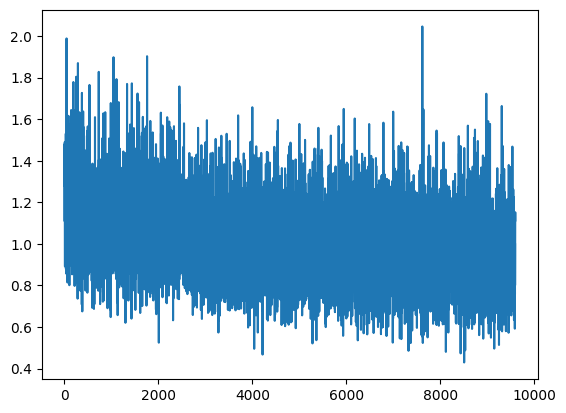

In [27]:
plt.plot(train_losses)

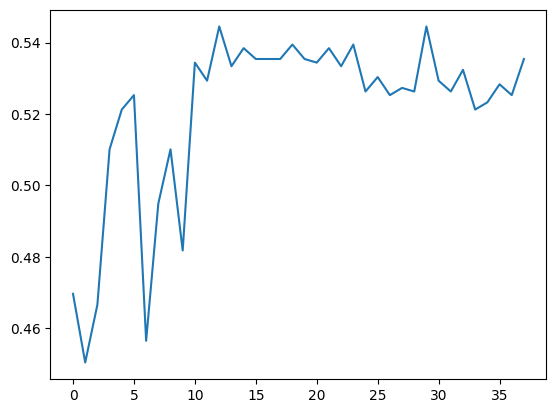

In [28]:
plt.plot(test_accuracy)

In [29]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 543/976 (0.5564)
{'acc_detail': tensor([0.6109, 0.6538, 0.6355, 0.2512], device='cuda:0'),
 'acc_unweighted': tensor(0.5379, device='cuda:0'),
 'acc_weighted': tensor(0.5564, device='cuda:0'),
 'f1s': tensor(0.5332, device='cuda:0'),
 'f1s_detail': tensor([0.5934, 0.6022, 0.6282, 0.3091], device='cuda:0'),
 'precision_detail': tensor([0.5769, 0.5581, 0.6210, 0.4016], device='cuda:0'),
 'recall_detail': tensor([0.6109, 0.6538, 0.6355, 0.2512], device='cuda:0'),
 'rocauc': tensor([0.8425, 0.7480, 0.8734, 0.7218], device='cuda:0'),
 'uar': tensor(0.5379, device='cuda:0'),
 'wap': tensor(0.5436, device='cuda:0')}


tensor([[135,  43,   9,  34],
        [ 22, 221,  60,  35],
        [  6,  65, 136,   7],
        [ 71,  67,  14,  51]], device='cuda:0')

In [30]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_iemocap4/iemocap4_m18emo4_best_13epoch.pt
Correct: 538/976 (0.5512)
{'acc_detail': tensor([0.5837, 0.7249, 0.5654, 0.2118], device='cuda:0'),
 'acc_unweighted': tensor(0.5215, device='cuda:0'),
 'acc_weighted': tensor(0.5512, device='cuda:0'),
 'f1s': tensor(0.5209, device='cuda:0'),
 'f1s_detail': tensor([0.5958, 0.6110, 0.6065, 0.2704], device='cuda:0'),
 'precision_detail': tensor([0.6085, 0.5280, 0.6541, 0.3739], device='cuda:0'),
 'recall_detail': tensor([0.5837, 0.7249, 0.5654, 0.2118], device='cuda:0'),
 'rocauc': tensor([0.8359, 0.7443, 0.8697, 0.7291], device='cuda:0'),
 'uar': tensor(0.5215, device='cuda:0'),
 'wap': tensor(0.5418, device='cuda:0')}


tensor([[129,  50,   5,  37],
        [ 17, 245,  51,  25],
        [  3,  80, 121,  10],
        [ 63,  89,   8,  43]], device='cuda:0')

In [31]:
np.save('../models_iemocap4/iemocap4_m18emo4_39epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_iemocap4/iemocap4_m18emo4_39epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [32]:
checkpoint_path = '../models_iemocap4/iemocap4_m18emo4_39epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 140

optimizer = optim.RAdam(model.parameters(), lr=0.000001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = '../models_iemocap4/iemocap4_m18emo4_200epoch.ckpt'
torch.save({
    'epoch': 200,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [43]:
# del model, best_model
# gc.collect()

565